In [15]:
import numpy as np 
import matplotlib.pyplot as plt 
import sys
sys.path.insert(1, "../")
from _shear_frame import ShearFrame_3D
from utils_OB import *
import koma.oma, koma.plot
import random
from scipy.signal import detrend, welch, resample
import koma.clustering
import seaborn as sns
import time
sns.set_theme(context='paper',font_scale=1, style = 'ticks', color_codes='bright')

t000=time.time()

Generating data for the last tracking-algortihm: 


In [16]:
def dynamic_stiffness_matrix(kx,ky,shapex,shapey): 
    '''Function for changing the stiffness matrix over time
    Arguments: 
        kx: 1darray: 
            stiffness for each floor in x-direction, first entry 
            correspons to the lower floor. Length n correspons to 
            the numer of floors i system.
        ky: 1darray
            Same as kx, but i y-direction
        shapex: 1darray or ndarray
            array of values to be multiplied with kx. if 1darray
            all floors have the same changes. 
            If ndarray each of the entries correspons to the development
            in each floor. 
        shapey: 1darray or ndarray
            Same shape as shapex

    Return: 
        Kxs: array
            array containing a kx vector for each entry in shape matrix
        Kys: array
            same as for Kxs
    '''
    # generating full shapes if they are 1d
    if len(np.shape(shapex))==1:
        n=len(kx)
        shapex=np.array([shapex]*n).T
    if len(np.shape(shapey))==1:
        n=len(ky)
        shapey=np.array([shapey]*n).T
     
    kxs=np.zeros_like(shapex)
    kys=np.zeros_like(shapex)
    for i in range(len(shapex)):
        kxs[i]=shapex[i]*kx
    for i in range(len(shapey)):
        kys[i]=shapey[i]*ky
    return kxs,kys


#### test: 
# kx=np.array([2,2,2])
# ky=np.array([2,2,2])
# shapex=np.array([[1,2,3],[1,1,1],[1,1,1],[10,10,10]])
# shapey=np.array([1,1,1,11])

# print(len(np.shape(shapex)))
# print(len(np.shape(shapey)))
# KKs=dynamic_stiffness_matrix(kx,ky,shapex,shapey)

# print(KKs[0])
# print(KKs[-1])

In [17]:
def generate_dynamic_series(kx, ky,shapex,shapey,M,t,*args,white_noise_amp=1,
next_segment='new',next_DOF='new',harmonic='decreasing',harmonic_part=1,
plot=False): 
    '''
    Arguments: 
        kx: 1darray: 
            stiffness for each floor in x-direction, first entry 
            correspons to the lower floor. Length n correspons to 
            the numer of floors i system.
        ky: 1darray
            Same as kx, but i y-direction
        shapex: 1darray or ndarray
            array of values to be multiplied with kx. if 1darray
            all floors have the same changes. 
            If ndarray each of the entries correspons to the development
            in each floor. 
        shapey: 1darray or ndarray
            Same shape as shapex
        M: 1darray
            mass for the floors. first entry is the mass of 
            the first floor.

    *args:
        If none of [next_segment,next_DOF,harmonic,harmonic_part] is 
        specified the same white noise loading are used for all
        DOFs, for all the time series.  

        next_segment: 'new' or'same'
                whether or not to creata a new set of loads 
                for each time segment

        next_DOF: 'new','same' or 'random'
                whether or not to create a new set of loading for each
                DOF. 'same' uses the same load series, new creates a new
                series with same parameters, randaom creates random params.
                as well.
        white_noise_amp: float
                the relative amplitude of the white noise 

        harmonic: string or None
            'random' crates a random freq. in the interval [0.5w_0,2w_n] w 
            are natural frqs of the frame.
            'decreasing' creates a decreasing frequenzy from [w_n , w_0]

        harmonic_part: float
            the harmonic amplitude in relation to the white noise. 0.5
            gives 50% of the amplitude. 

            

        plot: bolean
            Wether or not to plot the diagram

    Return:
        true_w: 2darray
            First axis are the time segments, first x-dir, then y-dir. 
            Second axis are the frequencies for each of the time series
        responses: 2d list of 2darrays
            list[i]=[ddu,du,u] response from time series i
            list[i][2]= u for time series i
            each with following shape: 
            u=[ [u1(t1),..., u1(tn)],
                [u2(t1),..., u2(tn)],
                .,
                [um(t1),..., um(tn)]
               ]
            where m = number of DOFS (m/2 number of floors)
                  n = length of each time series

            eg: responses[0][2][3,100]= first time series
                                        3. type (displacement,u)
                                        DOF number 4
                                        at timestep 101
                
        t: 1darray
            the time series used in each step. same for all steps. 
            
    '''
    
    n=len(shapex) #numer of time series to create
    m=len(kx)     # number of DOFs in each direction
    kxs,kys=dynamic_stiffness_matrix(kx,ky,shapex,shapey)
    frame=ShearFrame_3D()
    true_w=np.zeros((n,2*m))
    # t=np.linspace(0,3000,10000)
    responses=[]



    for i, kx_i in enumerate(kxs): #iterate the time segments
        ky_i=kys[i]
        frame.set_mass_and_stiffness(kx_i,ky_i,M)
        frame.set_damping()
        true_w[i]=np.hstack((frame.true_wx,frame.true_wy))**0.5
        

        if next_segment=='same' and i==0 :
            F=np.zeros((2*m,len(t)))
            if next_DOF == 'same':
                load=load_series(t)
                load.create_load(white_noise_amp,harmonic,harmonic_part,
                np.amax(true_w),np.amin(true_w))
                F=np.array([load.F]*2*m)

            elif next_DOF =='new': 
                for i in range(2*m):
                    load=load_series(t)
                    load.create_load(white_noise_amp,harmonic,harmonic_part,
                    np.amax(true_w),np.amin(true_w))
                    F[i]=load.F

            elif next_DOF=='random':
                for i in range(2*m):    
                    harm=random.choice(['random','decreasing',None])
                    harm_amp=random.randrange(1,50,1)/10
                    wna=random.random()*10
                    load=load_series(t)
                    load.create_load(wna,harm,harm_amp, 
                    np.amax(true_w),np.amin(true_w))
                    F[i]=load.F

        if next_segment=='new':
            F=np.zeros((2*m,len(t)))
            if next_DOF == 'same':
                load=load_series(t)
                load.create_load(white_noise_amp,harmonic,harmonic_part,
                np.amax(true_w),np.amin(true_w))
                F=np.array([load.F]*2*m)

            if next_DOF =='new':
                for i in range(2*m):
                    load=load_series(t)

                    load.create_load(white_noise_amp,
                    harmonic,harmonic_part,
                    np.amax(true_w),np.amin(true_w))

                    F[i]=load.F
            elif next_DOF=='random':
                for i in range(2*m):    
                    harm=random.choice(['random','decreasing',None])
                    harm_amp=random.randrange(1,50,1)/10
                    wna=random.random()*10
                    load=load_series(t)
                    load.create_load(wna,harm,harm_amp, 
                    np.amax(true_w),np.amin(true_w))
                    F[i]=load.F

        response_i=frame.simulate_response(t,F)
        responses.append(response_i)
            

    if plot: 
        t_plot=range(len(true_w))
        for i,ti in enumerate(t_plot):
            plt.scatter(np.ones(len(true_w[i]))*ti,true_w[i],c='black',s=5)
        plt.show()
        plt.show(frame.display_system(F,response_i[2],t,display_axis=True))
    return true_w,responses



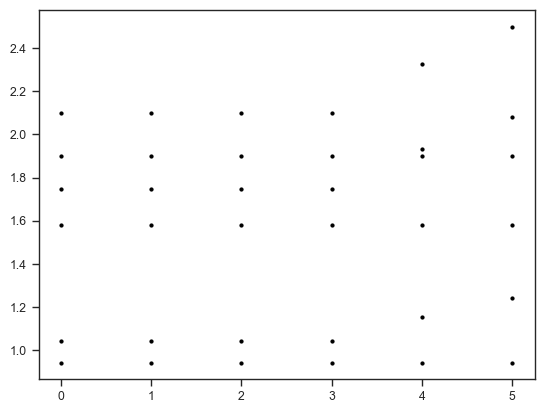

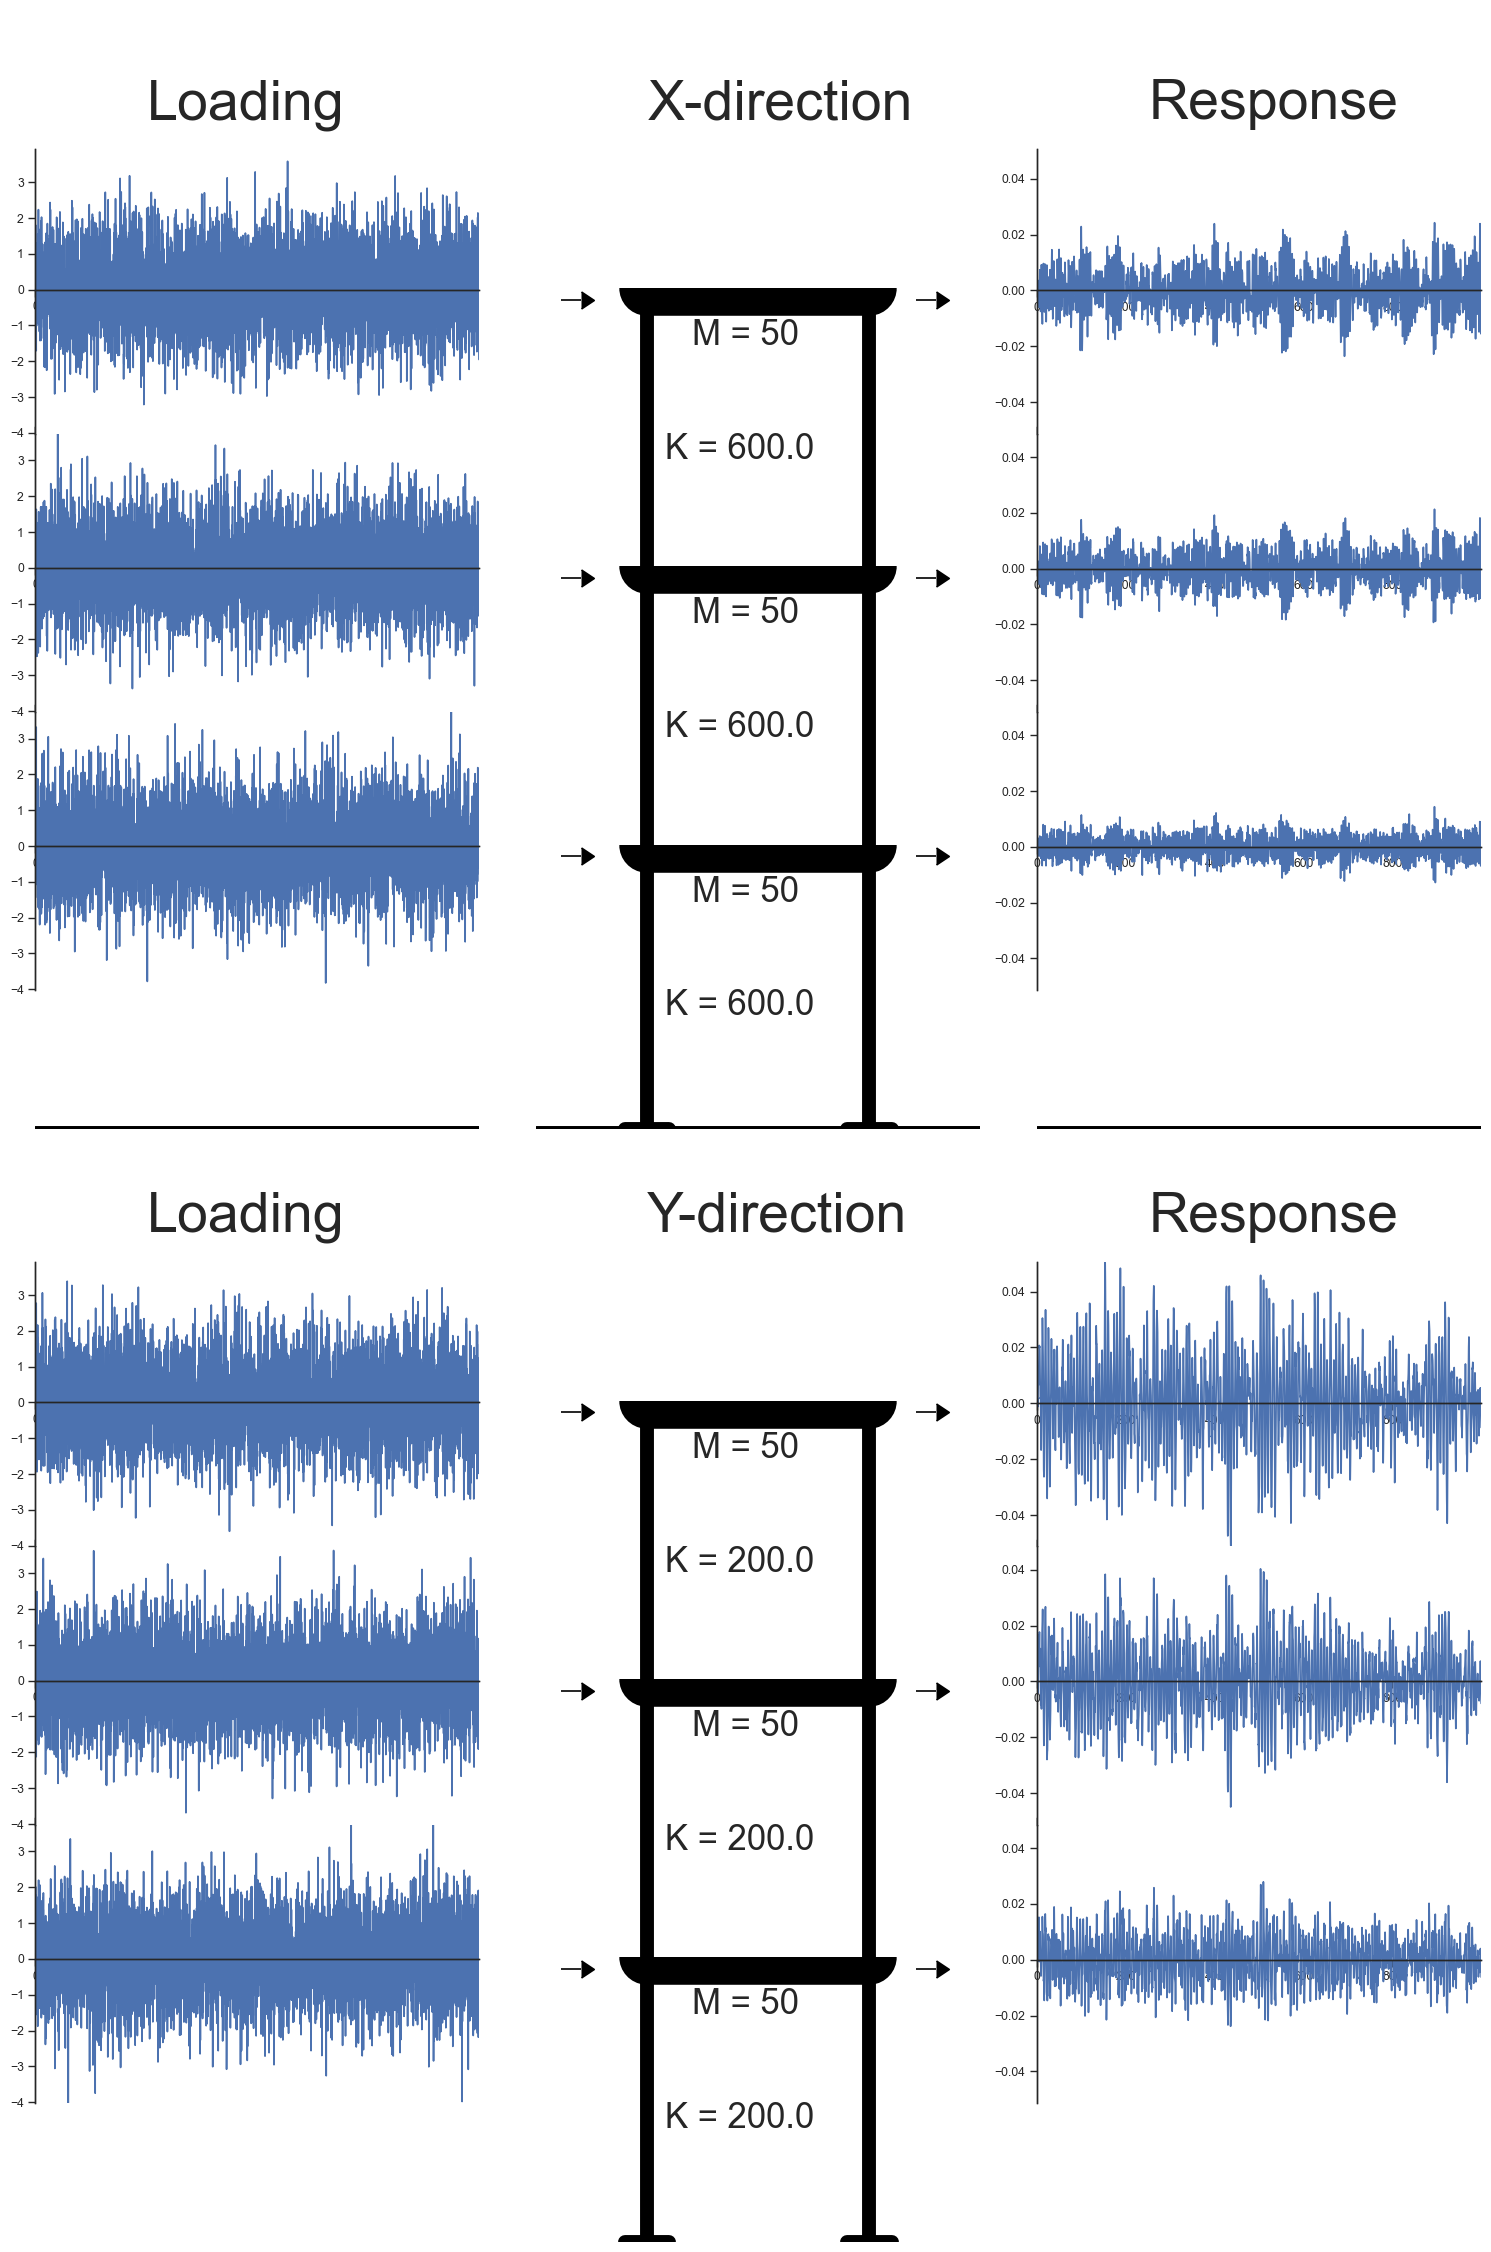

2.4984185840205417 0.9434424920604633
[[1.04409075 1.74770242 2.10091123 0.94344249 1.57922741 1.8983876 ]
 [1.04409075 1.74770242 2.10091123 0.94344249 1.57922741 1.8983876 ]
 [1.04409075 1.74770242 2.10091123 0.94344249 1.57922741 1.8983876 ]
 [1.04409075 1.74770242 2.10091123 0.94344249 1.57922741 1.8983876 ]
 [1.15547635 1.93415067 2.32504047 0.94344249 1.57922741 1.8983876 ]
 [1.24164015 2.07838015 2.49841858 0.94344249 1.57922741 1.8983876 ]]


In [40]:
kx=np.array([2,2,2])*150
ky=np.array([1,1,1])*200
m=np.array([1,1,1])*50


n=6
orders=np.arange(2,50,1)
fs=5        #Hz
T_max=1000  #sec
t=np.arange(0,T_max,1/fs)
shapey=np.ones(n)
shapex=np.hstack((np.ones(n//2),np.linspace(1,2,n//2)))


true_w,responses=generate_dynamic_series(kx, ky,shapex,shapey,m,t,white_noise_amp=1,
next_segment='same',next_DOF='new',harmonic='decreasing',harmonic_part=0.0,plot=True)
print(np.amax(true_w),np.amin(true_w))

print(true_w)


In [41]:
def add_noise_response(responses,noise_fac): 
    '''Function that adds noise to each measured series indevidually. 
    The noise are generated as the standard deviation of each indevidullay
    series, and multiplied with the noise_fac, and then added to 
    the measured series with a random factor from a standard 
    normal distribution. 
    Arguments: 
        responses: 2d list of 2darray
            list[i]=[ddu,du,u] response from time series i
            list[i][2]= u for time series i
            each with following shape: 
            u=[ [u1(t1),..., u1(tn)],
                [u2(t1),..., u2(tn)],
                .,
                [um(t1),..., um(tn)]
               ]
            where m = number of DOFS (m/2 number of floors)
                  n = length of each time series

            eg: responses[0][2][3,100]= first time series
                                        3. type (displacement,u)
                                        DOF number 4
                                        at timestep 101 
        noise_fac: float
            Factor to adjust size of added noise. 
    Returns: 
        response_noised: 2d list of 2d arrays
            Same shape as input, with noise. 
            '''
    responses_noised=[]
    for time_series in responses:
        response_noised=[]
        for response in time_series: 
            noise=np.std(response)*noise_fac
            # print(np.shape(response))
            noised= response + noise*np.random.randn(np.shape(response)[0],
                                            np.shape(response)[1])
            response_noised.append(noised)
        responses_noised.append(response_noised)
    return responses_noised




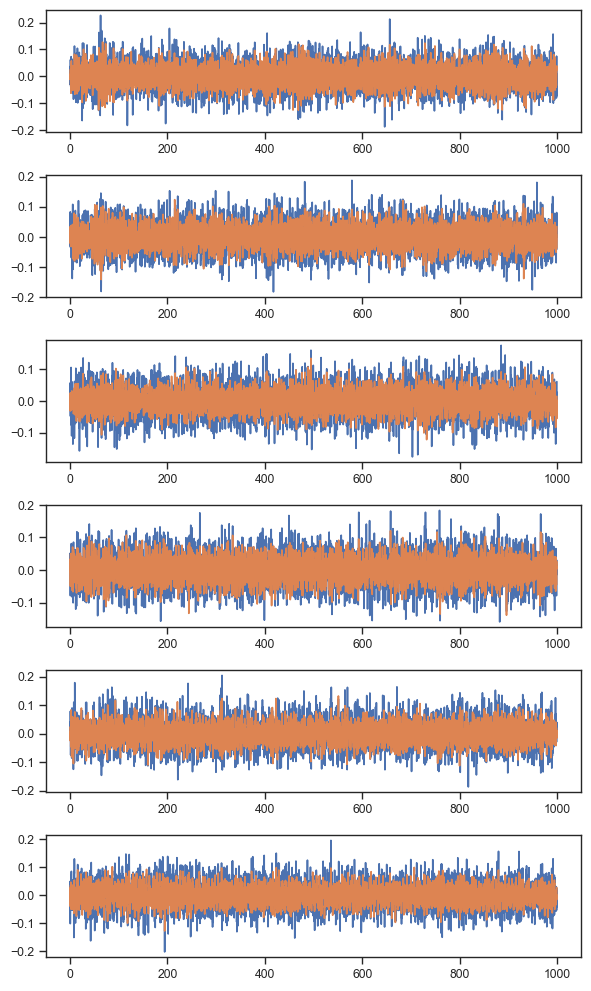

In [42]:
responses_noised=add_noise_response(responses,1)

k=1  # what time segment to compare
j=0    # waht response to compare (0=acceleration)

figure=plt.figure(figsize=(6,10))
for i in range(len(responses[k][j])):
    ax=plt.subplot2grid((6,1),(i,0),fig=figure)
    ax.plot(t,responses_noised[k][j][i])
    ax.plot(t,responses[k][j][i])
plt.tight_layout()
plt.show(figure)



In [43]:
def create_input_COVssi(responses,t,orders):
    '''
    Arguments:  
        responses: 2d list of 2darrays
            list[i]=[ddu,du,u] response from time series i
            list[i][2]= u for time series i
            each with following shape: 
            u=[ [u1(t1),..., u1(tn)],
                [u2(t1),..., u2(tn)],
                .,
                [um(t1),..., um(tn)]
               ]
            where m = number of DOFS (m/2 number of floors)
                  n = length of each time series

            eg: responses[0][2][3,100]= first time series
                                        3. type (displacement,u)
                                        DOF number 4
                                        at timestep 101
                
        t: 1darray
            the time series used in each step. same for all steps. 
    Returns: 
        phis: 2d list of 2d arrays
            eg: phis[0][1][3,4]= 
                            first time series
                            2. modal order
                            4. mode shape 
                            5. DOF 
                            
        lambds: 2d list of 1d arrays
            eg: phis[0][1][3]= first time series
                            2. modal order
                            eigenvalue for mode 4 
                       

    '''
    n_series=len(responses)
    depth=60
    phis=[]
    lambds=[]

    fs=len(t)/(t[-1]-t[0])
    for i,time_serie in enumerate(responses):
        response_i=time_serie[0] #acceleration
        lambd,phi=koma.oma.covssi(response_i.T,fs,depth,orders,algorithm='standard',showinfo=False)
        lambds.append(lambd)
        phis.append(phi)
    return lambds,phis

    

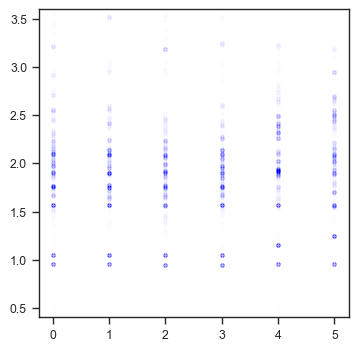

(0.4, 3.6)

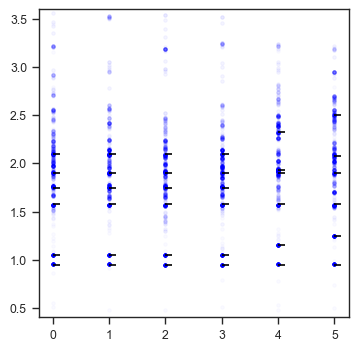

In [44]:
lambds,phis=create_input_COVssi(responses_noised,t,orders)


def w(lam):
    return np.abs(lam)**0.5

ys=[]
for i,series in enumerate(lambds):
    serie_i=np.array([])
    for j,order in enumerate(series):
        freqs=w(order)
        serie_i=np.append(serie_i,freqs)
    ys.append(serie_i)




plt.figure(figsize=(4,4))
for k,s in enumerate(ys): 
    plt.scatter(s*0+k,s,s=6,alpha=0.005,color='blue')
plt.ylim(0.4,3.6)
plt.show()

plt.figure(figsize=(4,4))
for k,s in enumerate(ys): 
    plt.scatter(s*0+k,s,s=6,alpha=0.02,color='blue')
    plt.scatter(true_w[k]*0+k,true_w[k],color='black',marker=1)
plt.ylim(0.4,3.6)


In [45]:
def clustering(lambds, phis,orders,s,stabcrit,valid_range,indicator,prob_threshold,
scaling,min_cluster_size,min_samples,*args,true_w=None,plot=False):
    '''
    Arguments: 
        lambds: 2d list of 1d arrays
            eg: phis[0][1][3]= first time series
                            2. modal order
                            eigenvalue for mode 4
        phis: 2d list of 2d arrays
            eg: phis[0][1][3,4]= 
                            first time series
                            2. modal order
                            4. mode shape 
                            5. DOF 
    Returns: 
                
    '''
    import time
    times={}
    t0=time.time()
    all_grouped_phis=[]
    all_grouped_lambds=[]
    for segment in range(len(lambds)): #iterate the time series
        times={}
        t0=time.time()
        lambd_i=lambds[segment]
        phi_i=phis[segment]



        lambd_stab, phi_stab, orders_stab, ix_stab =koma.oma.find_stable_poles(lambd_i, phi_i, orders, s, 
        stabcrit=stabcrit,valid_range=valid_range,
        indicator=indicator,return_both_conjugates=False)

        times['Stab_poles']=time.time()-t0


        pole_clusterer = koma.clustering.PoleClusterer(lambd_stab,
         phi_stab, orders_stab, min_cluster_size=min_cluster_size, 
         min_samples=min_samples,scaling=scaling)
        times['Cluster']=time.time()-t0


        args =pole_clusterer.postprocess(prob_threshold=prob_threshold, 
        normalize_and_maxreal=True)

        times['postprocess']=time.time()-t0

        xi_auto, lambds_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)

        times['grouping']=time.time()-t0

        omega_n_auto=np.array(lambds_n_auto)**0.5

        avg_phis=np.array([np.mean(np.array(phi),axis=1)for phi in phi_auto])
        
        avg_lambds=np.array([np.mean(lambd)for lambd in lambds_n_auto])

        
        all_grouped_phis.append(avg_phis)
        all_grouped_lambds.append(avg_lambds)
        

        if plot:
            
            plt.show(plot_stab_from_KOMA(omega_n_auto,order_auto,
            lambd_stab=lambd_stab,stab_orders=orders_stab,
             lambd=np.array(lambd_i),all_orders=(orders),
             true_w=true_w[segment],figsize=(8,6)))
            plt.close()

            times['plot']=time.time()-t0
            for key in times.keys():
                print(key,': ',np.round(times.get(key),5),'s')
                
    return all_grouped_phis,all_grouped_lambds
        
         

In [46]:
def plot_stab_from_KOMA(sorted_freqs,sorted_orders,*args,lambd_stab=None,stab_orders=np.zeros(1),lambd=None,all_orders=np.zeros(1),true_w=None,xmin=0,xmax=None,**kwargs):

    """Returns a figure with the clusters color coded  
    and with lines in between the poles in one cluster
    input: 
    Arguments: 
        sorted_freqs: 2darray
            first axis correspons to each order, second is freqs
            in that order
        sorted_orders: 1d array
            orders tht corresponds to sorted_freqs
        *args: 
            lambd: 2darray
                same type as sorted_freqs. Eigenvalues or 
                frequencies 
            all_orders: 1d array
                orders that correspons to lambd.
            true_w: 1darray
                Array ot the analythical natural frequencies
            figsize: (int,int)
            plot_negatives: bool
    
    """

    np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
    if not xmax: 
        xmax=np.amax(sorted_freqs[-1])*1.2
    if not xmin: 
        xmin=np.amin(sorted_freqs[0])*0.8
    

    # Make an arrays of colors. 
    colors=[]
    num=len(sorted_freqs)+8
    root=int(num**(1/3))
    root_rest=int(num/root**2)+1
    colors=[]
    for r in range(root):
        for g in range(root):
            for b in range(root_rest): 
                colors.append([r/root,g/root,b/root_rest])
    random.shuffle(colors)
           
    #create figure and plot scatter
    if 'figsize' in kwargs.keys():
        fig_s=kwargs['figsize']
    else:
        fig_s=(9,9)
    figur_h=plt.figure(figsize=fig_s)
    axes=figur_h.add_subplot(1,1,1)
    
    s_dot=fig_s[1]*3

    #The analythical freqs: 
    if np.any(true_w):
        lab=0
        for w in true_w:
            if lab==0:
                axes.axvline(w,linestyle='--',label='Analytichal freqs')
            else: 
                axes.axvline(w,linestyle='--')
            lab=1

    # plotting all the discarded poles: 
    if len(all_orders)>1:
        for i,order_i in enumerate(all_orders):
            lambd_i=lambd[i]         
            # xi=-np.real(lambd_i)/np.abs(lambd_i)
            # freq_i=np.imag(lambd_i)/(np.sqrt(1-xi**2))
            freq_i=np.abs(lambd_i)**0.5
            order_is=np.ones_like(freq_i)*order_i
            col='black'
            if i==0:
                axes.scatter(np.real(freq_i),order_is,color=col,
                marker='x',s=s_dot,label='Deleted poles')
            else:
                axes.scatter(np.real(freq_i),order_is,
                color=col,marker='x',s=s_dot)

    #plotting the poles that were deemed stable: 
    if len(stab_orders)>1:
        for i,order_i in enumerate(stab_orders):
            lambd_i=lambd_stab[i]         
            # xi=-np.real(lambd_i)/np.abs(lambd_i)
            # freq_i=np.imag(lambd_i)/(np.sqrt(1-xi**2))
            freq_i=np.abs(lambd_i)
            order_is=np.ones_like(freq_i)*order_i
            col='red'
            if i==0:
                axes.scatter(np.real(freq_i**0.5),order_is,color=col,
                marker='o',s=s_dot,label='Stable poles')
            else:
                axes.scatter(np.real(freq_i**0.5),order_is,
                color=col,marker='o',s=s_dot*1.5)

    
    
    #plotting the poles to keep, and the lines between them
    for i,order_i in enumerate(sorted_orders):
        freq_i=sorted_freqs[i]
        col=colors[i]
        size=s_dot*5/3
        axes.scatter(np.real(freq_i),order_i,marker='s',
        color=col,s=size,label='Mode '+str(i+1))
        axes.plot(np.real(freq_i),order_i,
        color=col,linewidth=size/20)
       
    axes.legend()
    axes.set_xlim(xmin,xmax)
    axes.set_ylabel('Modal order')
    axes.set_xlabel('Frequencies [rad/s]')
    plt.tight_layout() 
      
    return figur_h    

c:\Users\olebj\anaconda3\lib\site-packages\koma\clustering.py:46: RuntimeWarning: divide by zero encountered in true_divide
  diff = (arr1-arr2)/scaling
c:\Users\olebj\anaconda3\lib\site-packages\koma\clustering.py:46: RuntimeWarning: invalid value encountered in true_divide
  diff = (arr1-arr2)/scaling


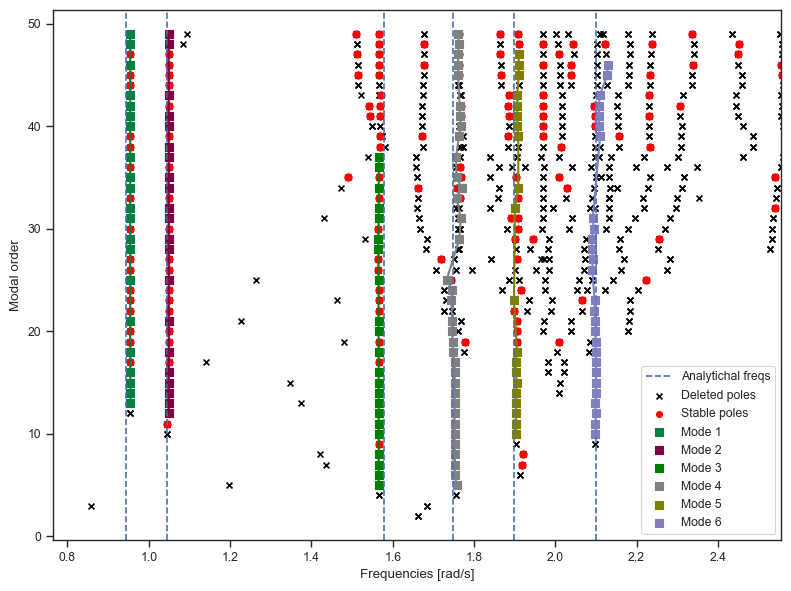

Stab_poles :  0.063 s
Cluster :  0.096 s
postprocess :  0.114 s
grouping :  0.114 s
plot :  3.13462 s


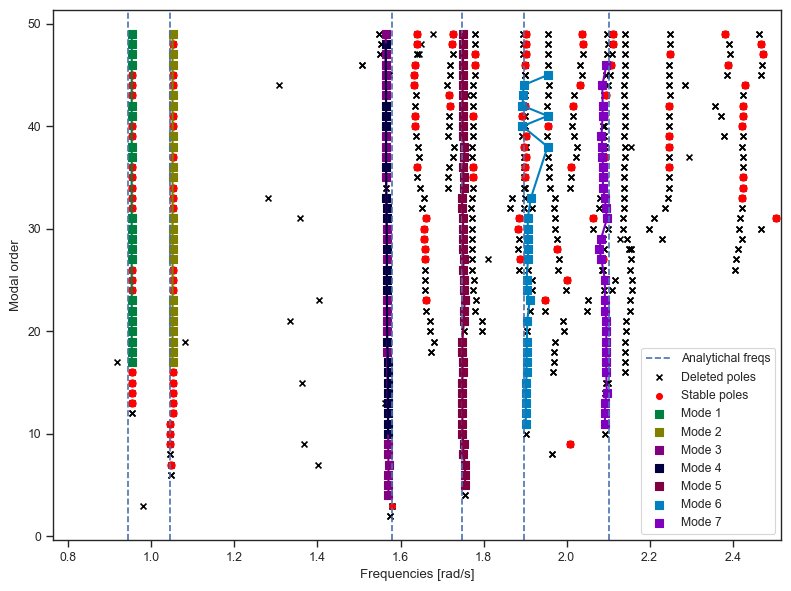

Stab_poles :  0.07304 s
Cluster :  0.10899 s
postprocess :  0.13799 s
grouping :  0.139 s
plot :  3.85106 s


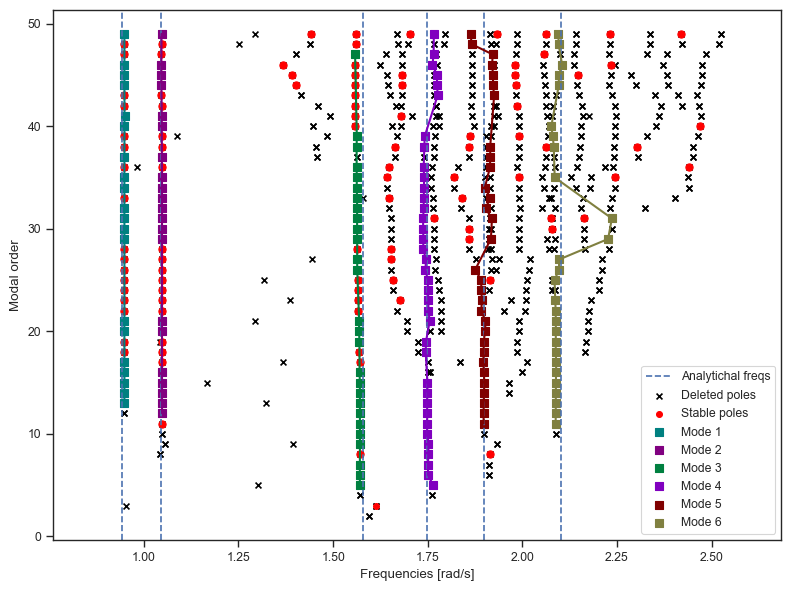

Stab_poles :  0.065 s
Cluster :  0.09501 s
postprocess :  0.12606 s
grouping :  0.12701 s
plot :  3.14497 s


c:\Users\olebj\anaconda3\lib\site-packages\koma\clustering.py:46: RuntimeWarning: divide by zero encountered in true_divide
  diff = (arr1-arr2)/scaling
c:\Users\olebj\anaconda3\lib\site-packages\koma\clustering.py:46: RuntimeWarning: invalid value encountered in true_divide
  diff = (arr1-arr2)/scaling


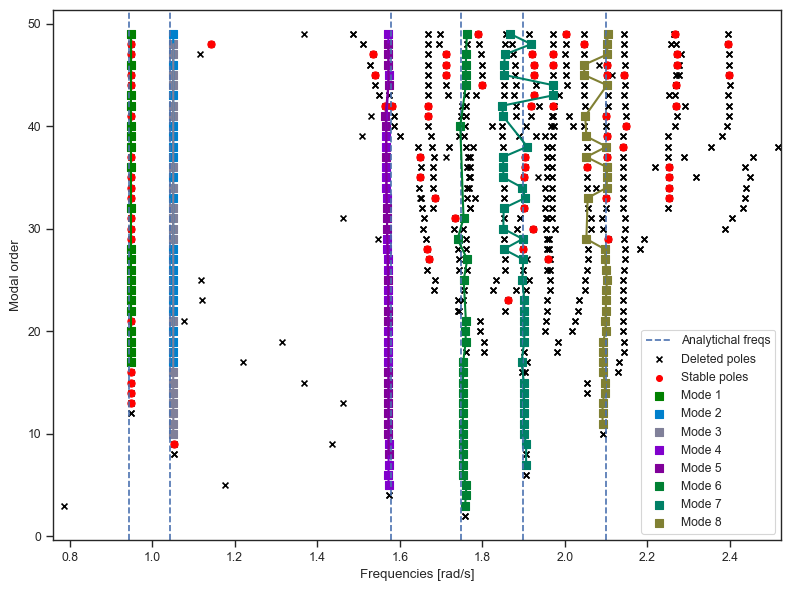

Stab_poles :  0.0722 s
Cluster :  0.1062 s
postprocess :  0.1282 s
grouping :  0.1292 s
plot :  2.91478 s


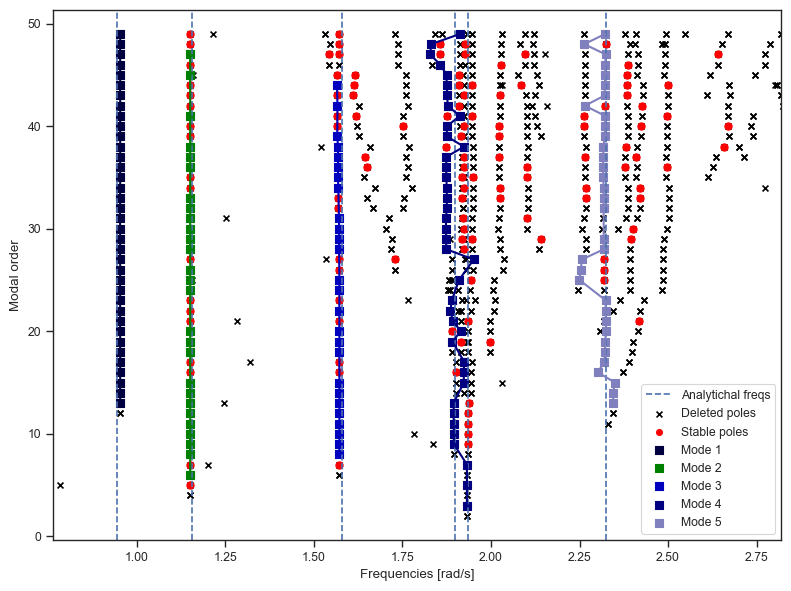

Stab_poles :  0.06874 s
Cluster :  0.10567 s
postprocess :  0.13067 s
grouping :  0.13067 s
plot :  2.91214 s


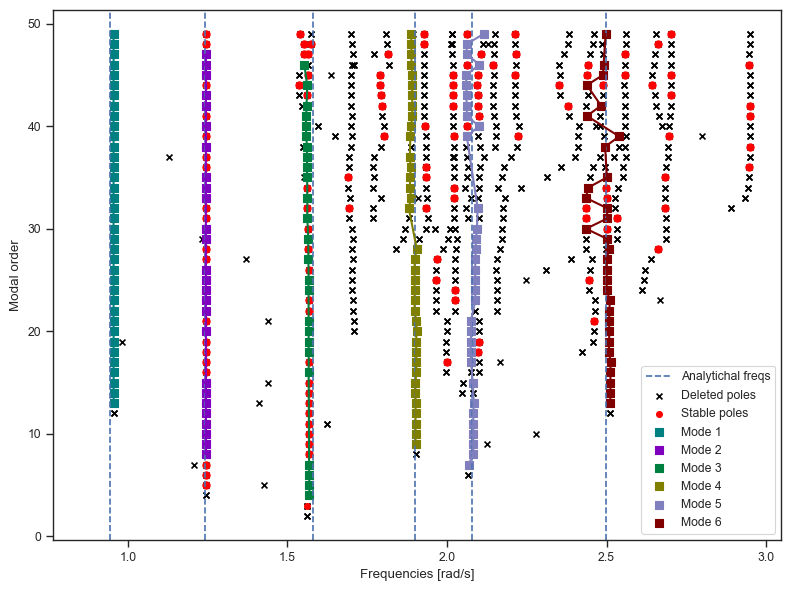

Stab_poles :  0.06206 s
Cluster :  0.101 s
postprocess :  0.139 s
grouping :  0.139 s
plot :  3.05462 s


In [47]:
valid_range= { 'freq': [1e-4, np.inf],'damping': [1e-4,np.inf] }

indicator='freq'
s=1
stabcrit = {'freq':0.05, 'damping': 0.1, 'mac': 0.1}
prob_threshold = 0.5   #probability of pole to belong to 
# cluster, based on estimated "probability" density function

min_cluster_size=20 
min_samples=10
scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0}


phis_out,lambds_out=clustering(lambds,
phis,orders,s,stabcrit,valid_range,indicator,prob_threshold,
scaling,min_cluster_size,min_samples,true_w=true_w,plot=True)

In [48]:
print((lambds_out[0]**0.5))
print(true_w[0,np.argsort(true_w[0])])

[0.95433788 1.04902863 1.56546057 1.7554096  1.90557905 2.10134022]
[0.94344249 1.04409075 1.57922741 1.74770242 1.8983876  2.10091123]


250.8007264137268


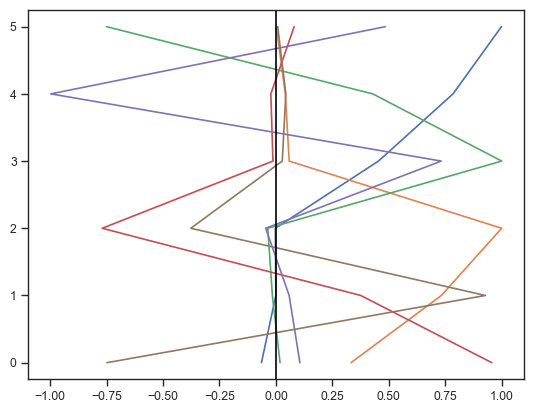

In [49]:
for phi in phis_out[0]: 
    plt.plot(np.real(phi),range(6))
plt.axvline(0,color='black')

print(time.time()-t000)

In [50]:
lambd_test=lambds[8]
phi_test=phis[8]
print(len(phis))
print(len(lambds))

s = 4

stabcrit = {'freq':0.1, 'damping': 0.2, 'mac': 0.1}

lambd_stab, phi_stab, orders_stab, ix_stab = koma.oma.find_stable_poles(lambd_test, phi_test, orders, s, stabcrit=stabcrit, indicator='freq',return_both_conjugates=False) 




IndexError: list index out of range

In [ ]:
nperseg = 1024*5
zp = 4
nfft = nperseg*zp

f, Pxx = welch(responses_noised[3][0][2], fs, 'hann', nperseg=nperseg, nfft=nfft)


c:\Users\olebj\miniconda3\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 5120 is greater than input length  = 5000, using nperseg = 5000
  warnings.warn('nperseg = {0:d} is greater than input length '


In [ ]:
fig = koma.plot.stabplot(lambd_stab, orders_stab, renderer='notebook', psd_freq=f*2*np.pi, psd_y=Pxx,frequency_unit='rad/s', freq_range=[0,1.1*np.amax(np.abs(lambd_stab))], damped_freq=False)


In [ ]:


pole_clusterer = koma.clustering.PoleClusterer(lambd_stab, phi_stab, orders_stab, min_cluster_size=10, min_samples=10, scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0})

prob_threshold = 0.7   #probability of pole to belong to cluster, based on estimated "probability" density function

args = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)

xi_auto, omega_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)
xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi

xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi

In [ ]:
print(fn_mean)

[0.14108507 0.17259631 0.17275778 0.39430659 0.39447903 0.48812063
 0.68839488]


In [ ]:
import pandas as pd
res_data = np.vstack([fn_mean, 100*xi_mean]).T
results = pd.DataFrame(res_data, columns=['$f_n$ [Hz]', r'$\xi$ [%]'])
results

$f_n$ [Hz]  $\xi$ [%]
0        0.14       6.07
1        0.17       3.11
2        0.17       3.24
3        0.39       4.86
4        0.39       4.89
5        0.49       3.50
6        0.69       2.52

In [ ]:
# Group only a selected quantity (e.g. indices)
lambd_used, phi_used, order_stab_used, group_ixs, all_single_ix, probs = pole_clusterer.postprocess(prob_threshold=prob_threshold)
grouped_ixs = koma.clustering.group_array(all_single_ix, group_ixs)       # for instance the indices only,
grouped_phis = koma.clustering.group_array(phi_used, group_ixs, axis=1)   # or the phis only


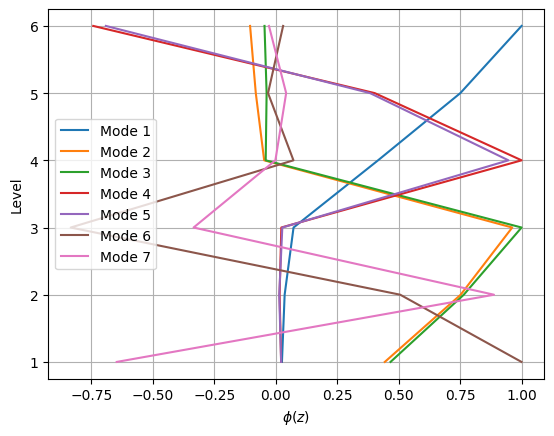

In [ ]:
# Mode shapes
for mode,phi_i in enumerate(grouped_phis):
    plt.plot(np.real(np.mean(phi_i, axis=1)), np.arange(6)+1, label=f'Mode {mode+1}')
    
plt.xlabel('$\phi(z)$')
plt.ylabel('Level')
plt.yticks(np.arange(6)+1)
plt.grid('on')
plt.legend()

C:\Users\olebj\AppData\Local\Temp\ipykernel_10256\3529449519.py:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

c:\Users\olebj\miniconda3\lib\site-packages\matplotlib\collections.py:193: ComplexWarning:

Casting complex values to real discards the imaginary part

c:\Users\olebj\OneDrive - NTNU\00Master - Onedrive\OB ymse\modal-tracking-thesis-spring-2023\src\tests\..\utils_OB.py:194: RuntimeWarning:

invalid value encountered in divide



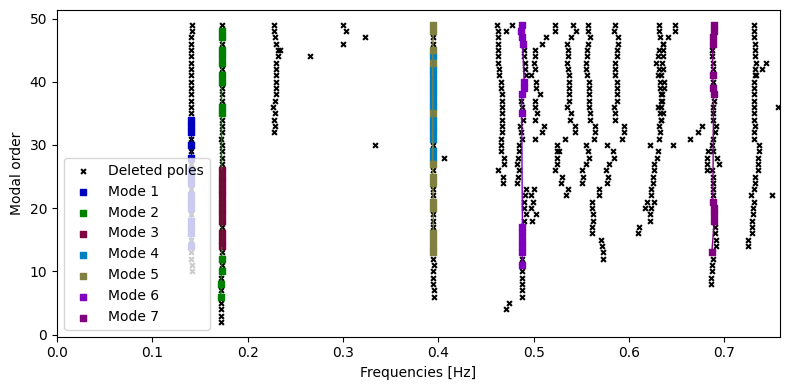

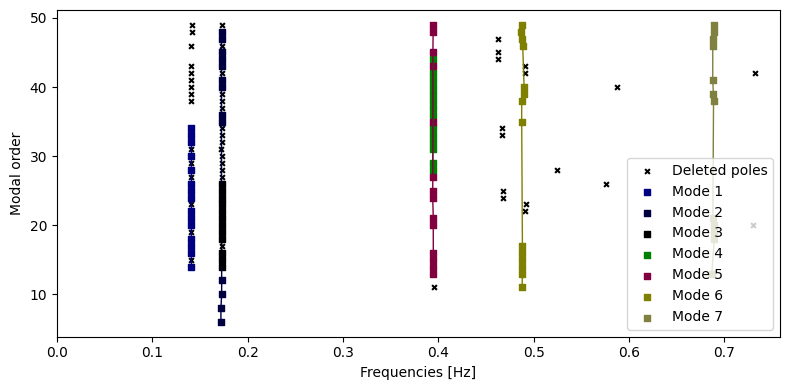

<__array_function__ internals>:180: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



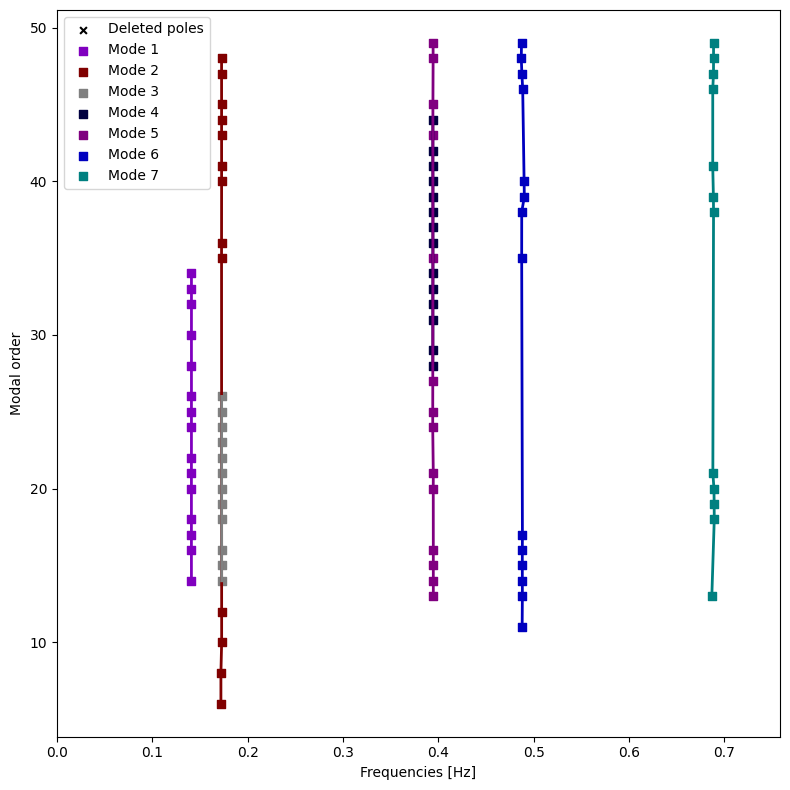

In [ ]:
plt.show(plot_stab_from_KOMA(omega_n_auto,order_auto,np.array(lambd_test),np.array(orders),figsize=(8,4)))
plt.show(plot_stab_from_KOMA(omega_n_auto,order_auto,lambd_stab,orders_stab,figsize=(8,4)))
plt.show(plot_stab_from_KOMA(omega_n_auto,order_auto,figsize=(8,8)))

In [ ]:
a=np.array([[1,1.1,0.9],[3,3,3],[6.5,7,6]])
b=a*2
c=a*3

D=np.array([a,b,c])
print(np.mean(D,axis=2))


[[ 1.   3.   6.5]
 [ 2.   6.  13. ]
 [ 3.   9.  19.5]]
